In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
#tf.compat.v1.disable_v2_behavior()

1 Physical GPUs, 1 Logical GPUs


In [2]:
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array,ImageDataGenerator
import numpy as np
from PIL import Image
import os 
import time
import matplotlib.pyplot as plt

In [3]:
# Generation resolution - Must be square 
# Training data is also scaled to this.
# Note GENERATE_RES 4 or higher  
# will blow Google CoLab's memory and have not
# been tested extensivly.
GENERATE_RES = 3 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 128 # rows/cols (should be square)
GEN_IMAGE_CHANNELS = 3
INPUT_IMAGE_CHANNELS = 1

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 1

# Configuration
DATA_PATH = 'output/colorised/'
EPOCHS = 50
BATCH_SIZE = 32
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 128px square images.


# Generating Images using Keras image data generator

In [4]:
bw_datagen = ImageDataGenerator(
    rescale= 1./255,
)

bw_image_generator = bw_datagen.flow_from_directory(
    "training/",
    class_mode=None,
    color_mode="grayscale",
    batch_size=1,
    target_size=(GENERATE_SQUARE, GENERATE_SQUARE),
    seed=123,
    shuffle=False
)


cl_datagen = ImageDataGenerator(
    rescale= 1./255
)

cl_image_generator = cl_datagen.flow_from_directory(
    "training/",
    class_mode=None,
    color_mode="rgb",
    batch_size=1,
    target_size=(GENERATE_SQUARE, GENERATE_SQUARE),
    seed=123,
    shuffle=False
)

Found 1304 images belonging to 1 classes.
Found 1304 images belonging to 1 classes.


In [5]:
def build_generator(channels, image_shape = (720,720,1)):
    model = Sequential()
    
    model.add(Input(shape=image_shape))
    
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model

In [6]:
def build_discriminator(image_shape=(720,720,3)):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [7]:
def save_images(cnt,noise):
    image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)

    generated_images = generator.predict(noise)

    generated_images = 0.5 * generated_images + 0.5

    image_count = 0
    for row in range(PREVIEW_ROWS):
        for col in range(PREVIEW_COLS):
            r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
            c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
            image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
                = generated_images[image_count] * 255
            image_count += 1


    output_path = os.path.join(DATA_PATH,'output')
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    filename = os.path.join(output_path,f"train-{cnt}.png")
    im = Image.fromarray(image_array)
    im.save(filename)

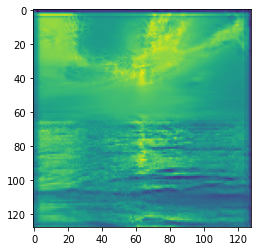

In [8]:
generator = build_generator(GEN_IMAGE_CHANNELS,(GENERATE_SQUARE,GENERATE_SQUARE,INPUT_IMAGE_CHANNELS))

bw_image = bw_image_generator.next()

generated_image = generator(bw_image, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [9]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,GEN_IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.4999683]], shape=(1, 1), dtype=float32)


In [10]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
#     print("Inside Discriminator Loss")
#     print(f'Real Loss: {real_loss}\nFake Loss: {fake_loss}\n\n')
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [11]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

In [60]:
@tf.function
def train_step(bw_images, cl_images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        print("Inside train_step")
        generated_images = generator(bw_images, training=True)
        
        real_output = discriminator(cl_images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        
#         print(f'Generator Gradients: {gradients_of_generator}\n\nDiscriminator Gradients: {gradients_of_discriminator}')
#         print(f'\n\n\nGenerator variables: {generator.trainable_variables}\n\nDiscriminator Variables: {discriminator.trainable_variables}')
        
#         print(f'Discriminator Gradients: {gradients_of_discriminator}\n\nDiscriminator Variables: {discriminator.trainable_variables}')
        
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
        print("Exiting train_step")
        
        return gen_loss, disc_loss

In [65]:
def train(gen_generator, disc_generator, epochs):
    start = time.time()
    
    for epochs in range(epochs):
        epoch_start = time.time()
        
        gen_loss_list = []
        disc_loss_list = []
        
        for bw_imagebatch, cl_imagebatch in zip(gen_generator,disc_generator):
            t = train_step(bw_imagebatch, cl_imagebatch)
            gen_loss_list.append(t[0])
            disc_loss_list.append(t[1])
            
        g_loss = sum(gen_loss_list) / len(gen_loss_list)
        d_loss = sum(disc_loss_list) / len(disc_loss_list)

        epoch_elapsed = time.time()-epoch_start
        
        print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
           ' {hms_string(epoch_elapsed)}')
        save_images(epoch,fixed_seed)

    elapsed = time.time()-start
    print (f'Training time: {hms_string(elapsed)}')

In [66]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 128)     1280      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 128)     512       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 128)     512       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 256)     2

In [67]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 33, 33, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 33, 33, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 33, 33, 64)       

In [ ]:
train(bw_image_generator, cl_image_generator, EPOCHS)

In [ ]:
generator.save(os.path.join(DATA_PATH,"face_generator.h5"))